In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from tqdm.auto import tqdm
import torch
from umap import UMAP

import pancancer_evaluation.config as cfg
from csd_simulations import simulate_csd
from fit_models import fit_k_folds_csd

np.random.seed(42)
torch.manual_seed(42)

%load_ext autoreload
%autoreload 2

### Simulate data from multiple "domains"

Main simulation code is in `09_simulations/csd_simulations.py`.

In [2]:
# see 09_simulations/csd_simulations.py for details on simulation parameters
n_domains = 6
n_per_domain = 50
p = 50
k = 5

# note one of the domains needs to be the testing domain
# so max(num_domains_range) should be strictly less than n_domains
num_domains_range = [1, 2, 3, 4, 5]

corr_top, diag = 1, None
# corr_top, diag = 0.5, 5
# corr_top, diag = 0.1, 10

# location to save plots to
output_plots = True
sim_results_dir = cfg.repo_root / '09_simulations' / 'simulation_results' / 'simulate_add_domains'
output_plots_dir = cfg.repo_root / '09_simulations' / 'simulation_plots' / 'simulate_add_domains'

In [3]:
xs, ys = simulate_csd(n_domains, n_per_domain, p, k, 
                      corr_noise=True,
                      corr_top=corr_top,
                      diag=diag)
domains = np.concatenate([([i] * n_per_domain) for i in range(n_domains)])

print(xs.shape)
print(xs[:5, :5])

(300, 50)
[[-0.99819298  0.7696853   3.88618494  1.09997108 -0.20305281]
 [-0.25416826  1.28536876  3.30992235  2.19756273 -3.40527529]
 [-0.01427958  2.177833    4.39865854  2.37742949  0.80465595]
 [-5.16174281  3.7666901  -1.442372    2.9849789   1.28975096]
 [-0.15880676  2.45547707  1.24267315 -1.23094201  1.11699211]]


In [4]:
print(ys.shape)
print(ys[:3, :])

(300, 1)
[[1]
 [1]
 [1]]


### Plot simulated data

We'll do this using both PCA and UMAP, side by side. We can color by domain and use different shapes for each label, to get an idea of how data clusters with respect to domain and how separable we expect different labels to be across domains.

In [5]:
pca = PCA(n_components=2)
X_proj_pca = pca.fit_transform(xs)
reducer = UMAP(n_components=2, random_state=42)
X_proj_umap = reducer.fit_transform(xs)

X_pca_df = pd.DataFrame(X_proj_pca,
                        columns=['PC{}'.format(j) for j in range(X_proj_pca.shape[1])])
X_pca_df['domain'] = domains
X_pca_df['label'] = ys.flatten()

X_umap_df = pd.DataFrame(X_proj_umap,
                        columns=['UMAP{}'.format(j) for j in range(X_proj_umap.shape[1])])
X_umap_df['domain'] = domains
X_umap_df['label'] = ys.flatten()

X_umap_df.head()

/home/jake/miniconda3/envs/pc-eval/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


,UMAP0,UMAP1,domain,label
0,-15.216463,4.163383,0,1
1,-15.917207,4.596262,0,1
2,-15.132104,4.569583,0,1
3,-16.336811,4.487727,0,-1
4,-15.153842,4.154551,0,1


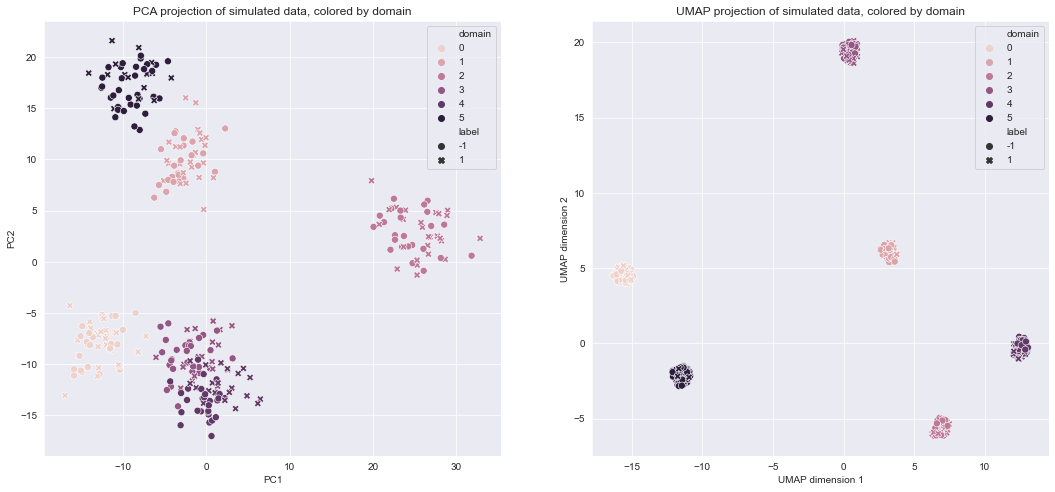

In [6]:
sns.set({'figure.figsize': (18, 8)})
fig, axarr = plt.subplots(1, 2)

sns.scatterplot(data=X_pca_df, x='PC0', y='PC1', hue='domain', style='label', s=50, ax=axarr[0])
sns.scatterplot(data=X_umap_df, x='UMAP0', y='UMAP1', hue='domain', style='label', s=50, ax=axarr[1])
    
axarr[0].set_title('PCA projection of simulated data, colored by domain')
axarr[0].set_xlabel('PC1')
axarr[0].set_ylabel('PC2')
axarr[0].legend()
axarr[1].set_title('UMAP projection of simulated data, colored by domain')
axarr[1].set_xlabel('UMAP dimension 1')
axarr[1].set_ylabel('UMAP dimension 2')
axarr[1].legend()

if output_plots:
    output_plots_dir.mkdir(exist_ok=True)
    plt.savefig(
        output_plots_dir / 'n{}_p{}_k{}_corr{}_scale{}_pca_umap.png'.format(
            n_domains, p, k, corr_top, diag),
    dpi=200, bbox_inches='tight')

### Fit models with varying (fixed) k

TODO: explain

In [7]:
def subset_domains(xs, ys, domains, num_train_domains):
    # first separate the holdout domain (make it the last one, arbitrarily)
    holdout_domain = np.unique(domains)[-1]
    X_holdout = xs[domains == holdout_domain, :]
    y_holdout = ys[domains == holdout_domain, :]
    ds_holdout = domains[domains == holdout_domain, np.newaxis]
    # now get the training data as the first num_train_domains domains
    # (again arbitrarily, the order shouldn't really matter)
    first_n_domains = list(range(num_train_domains))
    X_train = xs[np.isin(domains, first_n_domains), :]
    y_train = ys[np.isin(domains, first_n_domains), :]
    ds_train = domains[np.isin(domains, first_n_domains), np.newaxis]
    return (X_train, X_holdout, y_train, y_holdout, ds_train, ds_holdout)

In [8]:
holdout_split = subset_domains(xs, ys, domains, 5)
(X_train,
 X_holdout,
 y_train,
 y_holdout,
 ds_train,
 ds_holdout) = holdout_split

print(X_train.shape, y_train.shape, ds_train.shape)
print(X_holdout.shape, y_holdout.shape, ds_holdout.shape)

(250, 50) (250, 1) (250, 1)
(50, 50) (50, 1) (50, 1)


In [9]:
results_df = pd.DataFrame()
progress = tqdm(num_domains_range)
for num_train_domains in progress:
    progress.set_description('train domains: {}'.format(num_train_domains))
    holdout_split = subset_domains(xs, ys, domains, num_train_domains)
    (X_train,
     X_holdout,
     y_train,
     y_holdout,
     ds_train,
     ds_holdout) = holdout_split
    print(X_train.shape, y_train.shape, ds_train.shape)
    print(X_holdout.shape, y_holdout.shape, ds_holdout.shape)
    n_results_df = fit_k_folds_csd(
        X_holdout, y_holdout, ds_holdout,
        train_data=(X_train, y_train, ds_train)
    )
    n_results_df['num_train_domains'] = num_train_domains
    results_df = pd.concat((results_df, n_results_df))
    
results_df.head()

  0%|          | 0/5 [00:00<?, ?it/s]

(50, 50) (50, 1) (50, 1)
(50, 50) (50, 1) (50, 1)


  0%|          | 0/4 [00:00<?, ?it/s]

(100, 50) (100, 1) (100, 1)
(50, 50) (50, 1) (50, 1)


  0%|          | 0/4 [00:00<?, ?it/s]

(150, 50) (150, 1) (150, 1)
(50, 50) (50, 1) (50, 1)


  0%|          | 0/4 [00:00<?, ?it/s]

(200, 50) (200, 1) (200, 1)
(50, 50) (50, 1) (50, 1)


  0%|          | 0/4 [00:00<?, ?it/s]

(250, 50) (250, 1) (250, 1)
(50, 50) (50, 1) (50, 1)


  0%|          | 0/4 [00:00<?, ?it/s]

,fold,metric,value,num_train_domains
0,0,train_auroc,1.000000,1
1,1,train_auroc,1.000000,1
2,2,train_auroc,1.000000,1
3,3,train_auroc,1.000000,1
4,0,test_auroc,0.416667,1


(-0.1, 1.1)

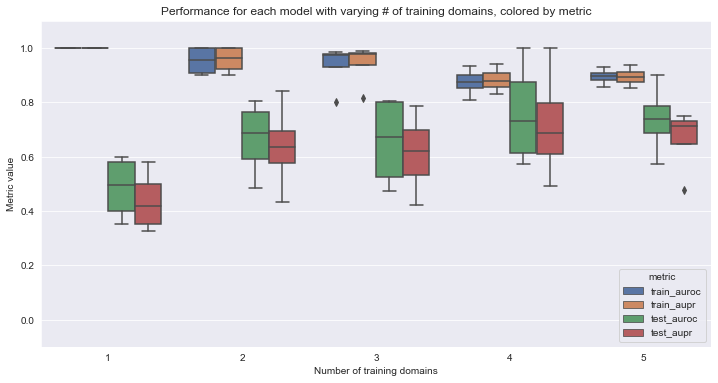

In [10]:
sns.set({'figure.figsize': (12, 6)})

sns.boxplot(
    data=results_df.sort_values(by=['num_train_domains'])
                   .sort_values(by=['metric'], ascending=False),
    x='num_train_domains', y='value', hue='metric'
)
plt.title(
    'Performance for each model with varying # of training domains, colored by metric'
    .format(k)
)
plt.xlabel('Number of training domains')
plt.ylabel('Metric value')
plt.ylim(-0.1, 1.1)

(-0.1, 1.1)

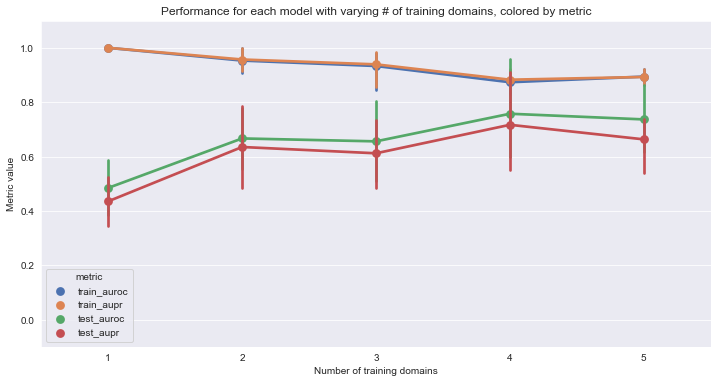

In [11]:
sns.set({'figure.figsize': (12, 6)})

sns.pointplot(
    data=results_df.sort_values(by=['num_train_domains'])
                   .sort_values(by=['metric'], ascending=False),
    x='num_train_domains', y='value', hue='metric'
)
plt.title(
    'Performance for each model with varying # of training domains, colored by metric'
    .format(k)
)
plt.xlabel('Number of training domains')
plt.ylabel('Metric value')
plt.ylim(-0.1, 1.1)